In [6]:
import pandas as pd
from IPython.display import display
import spacy
from spacy.tokens import Doc
from spacy.lang.pt.examples import sentences 

from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt 
from spacy.lang.pt.stop_words import STOP_WORDS

import requests
from bs4 import BeautifulSoup
import time

import nltk

#spacy.cli.download("pt_core_news_sm")


In [7]:
nlp = spacy.load('pt_core_news_sm')
punctuations = list(punctuation)


In [8]:
# Create a DataFrame to store the data analysed

df = pd.DataFrame({
    "Newspaper": [],
    "Number of occurences": [],
    "Period": []
    })


# Newspapers to search

newsp = ['cmjornal.pt/', 
         'dn.pt/',
         'expresso.pt/',
         'folhanacional.pt/',
         'jn.pt/',
         'ionline.sapo.pt/',   
         'sol.sapo.pt/',
         'observador.pt/',
         'publico.pt/',
         'sabado.pt/',
         'sapo.pt/',
         'visao.pt/',
         ]

# Years of the analysis

years = ['2019', '2020-2021', '2022-2024']

# Counting the number of occurrences for each of the newspapers in the defined periods

for y in years:
    with open("/Users/hannes_seidl/Desktop/UA_Aveiro/WS24:25/FDS/FDS_Project/cdx_results_json_files/cdx_results_"+y+".json", "r") as f:
        data = f.read()
        for i in newsp:
                total = data.count(i)
                df.loc[len(df)] = [i, total, y]

# Count the number of occurrences of each item in the URL column and save it to the dataframe w/o the timestamp

yearly_data = {}
yearly_data_no_dupl = {}
df_no_dupl = {}

for y in years:
    # Read the dataframe, count the number of URLs, merge the count to origina DF and then remove all duplicates based on URL
    df = pd.read_json("/Users/hannes_seidl/Desktop/UA_Aveiro/WS24:25/FDS/FDS_Project/cdx_results_json_files/cdx_results_"+y+".json")

    # Count the repeated urls in each of the .json files
    url_count = df.groupby(df['url']).size().reset_index(name = 'url count')

    # Merge the column (list) of counted values per url into the original DF
    yearly_data[f"df_{y}"] = df.merge(url_count, on = 'url', how = 'left')
    
    # Add the dataframes into a new dictionary
    yearly_data_no_dupl[f"df_{y}"] = yearly_data[f"df_{y}"].drop_duplicates(subset = ['url'], keep = 'first')

yearly_data_no_dupl['df_2019'].tail()

,url,timestamp,status,url count
13877,https://www.sapo.pt/prime/article/fc-porto-che...,1970-08-22 16:33:44.171433,200,127
13878,https://www.sapo.pt/prime/article/fc-porto-che...,1970-08-22 16:33:44.175956,200,1
13895,http://www.sapo.pt/prime/article/fc-porto-cheg...,1970-08-22 16:35:02.011304,200,2
13896,http://www.sapo.pt/prime/article/fc-porto-cheg...,1970-08-22 16:35:02.011308,200,2
13898,http://www.sapo.pt/prime/article/fc-porto-cheg...,1970-08-22 16:35:02.021135,200,2


In [9]:
# Function to process the title
def title_input(df, year): 
    processed_texts = []  # Initialize inside the function

    # Extract the last part of each URL and process it with SpaCy
    last_part = df['url'].str.rsplit('/').str[-1]
    for part in last_part:
        if "-" in part:
            parts = part.rsplit('-')[0:-1]  # Split by '-' and remove the last element
            sentence = " ".join(parts)  # Join parts to form a sentence
            processed_sentence = nlp(sentence)  # Process with SpaCy
            processed_texts.append(" ".join(token.text for token in processed_sentence))
        else:
            processed_texts.append("")  # Append an empty string if no processing was done

    # Use .loc to avoid SettingWithCopyWarning
    df = df.copy()  # Create a copy to avoid SettingWithCopyWarning if df is a slice
    df.loc[:, 'processed_url_text'] = processed_texts
    
    # Drop duplicates based on the 'processed_url_text' column within the df DataFrame
    df = df.drop_duplicates(subset=['processed_url_text'], keep='first').reset_index(drop=True)
    
    # Update the original DataFrame dictionary with the filtered DataFrame
    yearly_data_no_dupl[f"df_{year}"] = df
    
    return df


In [10]:
# Function to filter the dataframe, for links with "chega" and "andre ventura"
def filter_dataframe(df, text_column="processed_url_text"):
    # List to keep track of row indices that meet the criteria
    indices_to_keep = []

    # Iterate over each row in the DataFrame to access both the index and text
    for index, row in df.iterrows():
        text = row[text_column]
        
        # Skip if the text is NaN
        if pd.isna(text):
            continue
        
        doc = nlp(text)

        # Check if "chega" appears as a noun in the document
        is_chega_noun = any(token.text.lower() == "chega" and token.pos_ == "NOUN" for token in doc)

        # Check if both "andre" and "ventura" appear in the document
        contains_andre_ventura = "andre" in text.lower() and "ventura" in text.lower()

        # If either condition is met, keep the row index
        if is_chega_noun or contains_andre_ventura:
            indices_to_keep.append(index)

    # Filter the DataFrame to only include rows that meet the criteria
    df = df.loc[indices_to_keep].reset_index(drop=True)
    
    return df


In [11]:
# Create a dictionary to store the filtered dataframes

filtered_dfs = {}
# Apply the title_input and filter_dataframe functions
for y in years:
    yearly_data_no_dupl[f"df_{y}"] = title_input(yearly_data_no_dupl[f"df_{y}"], y)
    filtered_dfs[f"filtered_df_{y}"] = filter_dataframe(yearly_data_no_dupl[f"df_{y}"])
    filtered_dfs[f"filtered_df_{y}"] = filtered_dfs[f"filtered_df_{y}"].rename(columns={"processed_url_text": "title"})

print(filtered_dfs['filtered_df_2019'])

                                                  url  \
0   https://www.cmjornal.pt/opiniao/colunistas/edu...   
1   https://www.cmjornal.pt/politica/amp/andre-ven...   
2   https://www.cmjornal.pt/politica/amp/andre-ven...   
3   https://www.cmjornal.pt/politica/amp/andre-ven...   
4   https://www.cmjornal.pt/politica/amp/andre-ven...   
..                                                ...   
89  https://ionline.sapo.pt/artigo/679333/projeto-...   
90  https://www.sapo.pt/noticias/amp/nacional/depu...   
91  https://www.sapo.pt/noticias/nacional/cristas-...   
92  https://www.sapo.pt/noticias/nacional/listas-d...   
93  https://www.sapo.pt/noticias/nacional/ventura-...   

                    timestamp  status  url count  \
0  1970-08-22 16:36:58.180706     200          2   
1  1970-08-22 16:37:08.191131     200          6   
2  1970-08-22 16:37:06.194953     200          2   
3  1970-08-22 16:40:16.180531     200         18   
4  1970-08-22 16:36:47.114254     200          2   
.. 

In [12]:
# Function to find the newspaper name in the URL
def find_newspaper(url):
    for newspaper in newsp:
        if newspaper in url:
            return newspaper
    return None  # Return None if no newspaper is found

# Create the 'newspaper' column
for y in years:
    filtered_dfs[f"filtered_df_{y}"]['newspaper'] = filtered_dfs[f"filtered_df_{y}"]['url'].apply(find_newspaper)

filtered_dfs['filtered_df_2022-2024']

,url,timestamp,status,url count,title,newspaper
0,https://www.cmjornal.pt/mais-cm/perguntas-cm/d...,1970-08-23 06:27:01.001045,200,1,imigracao aceita se referendo exigido pelo che...,cmjornal.pt/
1,https://www.cmjornal.pt/politica/detalhe/20220...,1970-08-23 00:46:41.170435,200,2,20220401 0241 chega e il parlamento exclui vot...,cmjornal.pt/
2,https://www.cmjornal.pt/politica/detalhe/edite...,1970-08-23 00:46:41.183725,200,2,edite estrela e adao e silva sao os novos vice...,cmjornal.pt/
3,https://www.cmjornal.pt/politica/detalhe/luis-...,1970-08-23 06:18:27.105109,200,1,luis montenegro diz nao ao chega e andre ventu...,cmjornal.pt/
4,https://expresso.pt/api/molecule/sidenav/menu?...,1970-08-23 06:18:45.201434,200,1,2022 02 03 o candidato do chega a vice preside...,expresso.pt/
...,...,...,...,...,...,...
200,https://www.sapo.pt/amp/noticias/atualidade/mo...,1970-08-23 00:55:18.234246,200,1,mocao de confianca de andre ventura aprovada,sapo.pt/
201,https://www.sapo.pt/rd/andre-ventura-ataca-ivo...,1970-08-23 00:48:37.193408,200,2,andre ventura ataca ivo lucas apos,sapo.pt/
202,https://www.sapo.pt/rd/andre-ventura-da-carta-...,1970-08-23 00:48:22.182606,200,4,andre ventura da carta branca a jose pacheco,sapo.pt/
203,https://www.sapo.pt/rd/andre-ventura-nao-vou-d...,1970-08-23 00:55:19.190529,200,3,andre ventura nao vou desistir ate ser,sapo.pt/


In [13]:
# Function to generate the Arquivo.pt link based on timestamp and original URL
def generate_arquivo_link(row):
    base_url = "https://arquivo.pt/wayback/"
    # Format timestamp to Arquivo format "YYYYMMDDHHMMSS"
    timestamp_str = row['timestamp'].strftime('%Y%m%d%H%M%S')
    arquivo_link = f"{base_url}{timestamp_str}/{row['url']}"
    return arquivo_link

# Function to scrape the content of an Arquivo.pt link
def scrape_article_content(url):
    try:
        response = requests.get(url, timeout=50)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'lxml')
        
        # Find all <p> tags and concatenate their text
        paragraphs = soup.find_all('p')
        article_text = " ".join([p.get_text() for p in paragraphs])
        
        # Return the article text or None if no <p> elements are found
        return article_text if article_text.strip() else None

    except requests.exceptions.RequestException as e:
        print(f"Error scraping {url}: {e}")
        return None

# Process each filtered DataFrame and update with Arquivo links and article content
for y in years:
    df = filtered_dfs[f"filtered_df_{y}"]

    # Generate Arquivo link for each row and scrape article content
    #df['arquivo_url'] = df.apply(generate_arquivo_link, axis=1)
    df['article_text'] = df['url'].apply(scrape_article_content)

    # Optional: Add delay to avoid overloading the server and getting blocked
    time.sleep(1)

    # Update the filtered DataFrame in the dictionary
    filtered_dfs[f"filtered_df_{y}"] = df

Error scraping https://www.cmjornal.pt/multimedia/videos/amp/andre-ventura-bruno-fernandes-nao-tem-o-nivel-de-estrelato-la-fora-que-tem-em-portugal: 404 Client Error: Not Found for url: https://www.cmjornal.pt/error/404?url=/multimedia/videos/amp/andre-ventura-bruno-fernandes-nao-tem-o-nivel-de-estrelato-la-fora-que-tem-em-portugal
Error scraping https://www.cmjornal.pt/multimedia/videos/amp/andre-ventura-comenta-reacao-de-luis-filipe-vieira-na-assembleia-geral-do-benfica: 404 Client Error: Not Found for url: https://www.cmjornal.pt/error/404?url=/multimedia/videos/amp/andre-ventura-comenta-reacao-de-luis-filipe-vieira-na-assembleia-geral-do-benfica
Error scraping https://www.cmjornal.pt/multimedia/videos/amp/andre-ventura-compara-salario-de-varandas-ao-de-bruno-de-carvalho: 404 Client Error: Not Found for url: https://www.cmjornal.pt/error/404?url=/multimedia/videos/amp/andre-ventura-compara-salario-de-varandas-ao-de-bruno-de-carvalho
Error scraping https://www.cmjornal.pt/multimedia/

In [14]:
filtered_dfs['filtered_df_2019']

,url,timestamp,status,url count,title,newspaper,article_text
0,https://www.cmjornal.pt/opiniao/colunistas/edu...,1970-08-22 16:36:58.180706,200,2,rap promotor do chega de,cmjornal.pt/,"Podcasts, Videocast e Programas sobre principa..."
1,https://www.cmjornal.pt/politica/amp/andre-ven...,1970-08-22 16:37:08.191131,200,6,andre ventura diz chega vai impedir extrema di...,cmjornal.pt/,"Podcasts, Videocast e Programas sobre principa..."
2,https://www.cmjornal.pt/politica/amp/andre-ven...,1970-08-22 16:37:06.194953,200,2,andre ventura do chega nao vai a posse do gove...,cmjornal.pt/,"Podcasts, Videocast e Programas sobre principa..."
3,https://www.cmjornal.pt/politica/amp/andre-ven...,1970-08-22 16:40:16.180531,200,18,andre ventura el ultraderechista portugues dep...,cmjornal.pt/,"Podcasts, Videocast e Programas sobre principa..."
4,https://www.cmjornal.pt/politica/amp/andre-ven...,1970-08-22 16:36:47.114254,200,2,andre ventura fala em feito historico do chega...,cmjornal.pt/,"Podcasts, Videocast e Programas sobre principa..."
...,...,...,...,...,...,...,...
89,https://ionline.sapo.pt/artigo/679333/projeto-...,1970-08-22 16:40:07.181559,200,1,projeto de castracao quimica do chega ja foi e...,ionline.sapo.pt/,Ventura defende que é «o caminho mais eficaz n...
90,https://www.sapo.pt/noticias/amp/nacional/depu...,1970-08-22 16:38:41.195155,200,1,deputado do chega e recebido com aplausos,sapo.pt/,"Envergando uma 't-shirt' do movimento Zero, co..."
91,https://www.sapo.pt/noticias/nacional/cristas-...,1970-08-22 16:33:48.172147,200,1,cristas so exclui chega de conversas,sapo.pt/,"""Eu sempre disse que, para termos 116 deputado..."
92,https://www.sapo.pt/noticias/nacional/listas-d...,1970-08-22 16:33:25.172133,200,1,listas do chega vao integrar elementos,sapo.pt/,"""No âmbito do processo eleitoral em curso, e t..."


In [15]:
# Function to generate the Arquivo.pt link based on timestamp and original URL
def generate_arquivo_link(row):
    base_url = "https://arquivo.pt/wayback/"
    # Format timestamp to Arquivo format "YYYYMMDDHHMMSS"
    timestamp_str = row['timestamp'].strftime('%Y%m%d%H%M%S')
    arquivo_link = f"{base_url}{timestamp_str}/{row['url']}"
    return arquivo_link

# Function to scrape the content of an Arquivo.pt link
def scrape_article_content(url):
    try:
        response = requests.get(url, timeout=50)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'lxml')
        
        # Find all <p> tags and concatenate their text
        paragraphs = soup.find_all('p')
        article_text = " ".join([p.get_text() for p in paragraphs])
        
        # Return the article text or None if no <p> elements are found
        return article_text if article_text.strip() else None

    except requests.exceptions.RequestException as e:
        print(f"Error scraping {url}: {e}")
        return None

updated_dfs = {}
# Process each filtered DataFrame and update with Arquivo links and article content
for y in years:
    df = filtered_dfs[f"filtered_df_{y}"]

    # Generate Arquivo link for each row and scrape article content
    df['arquivo_url'] = df.apply(generate_arquivo_link, axis=1)
    df['article_text'] = df['url'].apply(scrape_article_content)

    # Optional: Add delay to avoid overloading the server and getting blocked
    time.sleep(1)

    # Update the filtered DataFrame in the dictionary
    updated_dfs[f"filtered_df_{y}"] = df

Error scraping https://www.cmjornal.pt/multimedia/videos/amp/andre-ventura-bruno-fernandes-nao-tem-o-nivel-de-estrelato-la-fora-que-tem-em-portugal: 404 Client Error: Not Found for url: https://www.cmjornal.pt/error/404?url=/multimedia/videos/amp/andre-ventura-bruno-fernandes-nao-tem-o-nivel-de-estrelato-la-fora-que-tem-em-portugal
Error scraping https://www.cmjornal.pt/multimedia/videos/amp/andre-ventura-comenta-reacao-de-luis-filipe-vieira-na-assembleia-geral-do-benfica: 404 Client Error: Not Found for url: https://www.cmjornal.pt/error/404?url=/multimedia/videos/amp/andre-ventura-comenta-reacao-de-luis-filipe-vieira-na-assembleia-geral-do-benfica
Error scraping https://www.cmjornal.pt/multimedia/videos/amp/andre-ventura-compara-salario-de-varandas-ao-de-bruno-de-carvalho: 404 Client Error: Not Found for url: https://www.cmjornal.pt/error/404?url=/multimedia/videos/amp/andre-ventura-compara-salario-de-varandas-ao-de-bruno-de-carvalho
Error scraping https://www.cmjornal.pt/multimedia/

In [16]:
updated_dfs['filtered_df_2020-2021']['article_text']

0      Podcasts, Videocast e Programas sobre principa...
1      Podcasts, Videocast e Programas sobre principa...
2                                                   None
3                                                   None
4      Podcasts, Videocast e Programas sobre principa...
                             ...                        
660                                                 None
661    \tEm pouco mais de um minuto, no debate sobre ...
662    Em causa está uma entrevista hoje divulgada pe...
663                                                 None
664                                                 None
Name: article_text, Length: 665, dtype: object

In [17]:
nltk.download('STOP_WORDS')
stopwords = nltk.corpus.stopwords.words('portuguese')

print(stopwords[:10])

# Empty dictionary to introduce the tokens
lemmas_dict = {}

stop_words = STOP_WORDS

# Loop through each review along with its index
for index, review in enumerate(updated_dfs['filtered_df_2020-2021']['article_text']):
    if review is None:
        print(f"Skipping index {index} because the review is None")
        continue
    doc = nlp(review)
    lemmas = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in doc ]
    lemmas = [ word for word in lemmas if word not in stop_words and word not in punctuations ]
    lemmas_dict[index] = lemmas  # Store lemmas in the dictionary with index as key

# Convert dictionary to a series and assign as a new column in the DataFrame
updated_dfs['filtered_df_2020-2021']['Lemmas'] = pd.Series(lemmas_dict)

[nltk_data] Error loading STOP_WORDS: Package 'STOP_WORDS' not found
[nltk_data]     in index


['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as']
Skipping index 2 because the review is None
Skipping index 3 because the review is None
Skipping index 32 because the review is None
Skipping index 33 because the review is None
Skipping index 34 because the review is None
Skipping index 35 because the review is None
Skipping index 36 because the review is None
Skipping index 38 because the review is None
Skipping index 39 because the review is None
Skipping index 44 because the review is None
Skipping index 66 because the review is None
Skipping index 71 because the review is None
Skipping index 74 because the review is None
Skipping index 89 because the review is None
Skipping index 113 because the review is None
Skipping index 115 because the review is None
Skipping index 121 because the review is None
Skipping index 122 because the review is None
Skipping index 123 because the review is None
Skipping index 124 because the review is None
Skipping index

In [19]:
updated_dfs['filtered_df_2020-2021']['Lemmas']
filtered_df = updated_dfs['filtered_df_2020-2021'].dropna(subset=['article_text'])
print(filtered_df)

                                                   url  \
0    https://www.cmjornal.pt/desporto/futebol/amp/d...   
1    https://www.cmjornal.pt/multimedia/fotogaleria...   
4    https://www.cmjornal.pt/politica/amp/andre-ven...   
5    https://www.cmjornal.pt/politica/amp/aprovada-...   
6    https://www.cmjornal.pt/politica/amp/aprovado-...   
..                                                 ...   
657  https://www.sapo.pt/amp/noticias/atualidade/an...   
658  https://www.sapo.pt/amp/noticias/atualidade/an...   
659  https://www.sapo.pt/amp/noticias/atualidade/di...   
661  https://www.sapo.pt/noticias/amp/nacional/andr...   
662  https://www.sapo.pt/noticias/amp/nacional/andr...   

                     timestamp  status  url count  \
0   1970-08-22 19:15:06.171105     200          8   
1   1970-08-22 19:17:07.182040     200          2   
4   1970-08-22 19:08:44.190851     200          4   
5   1970-08-22 19:10:03.181044     200          2   
6   1970-08-22 19:10:06.190139     200

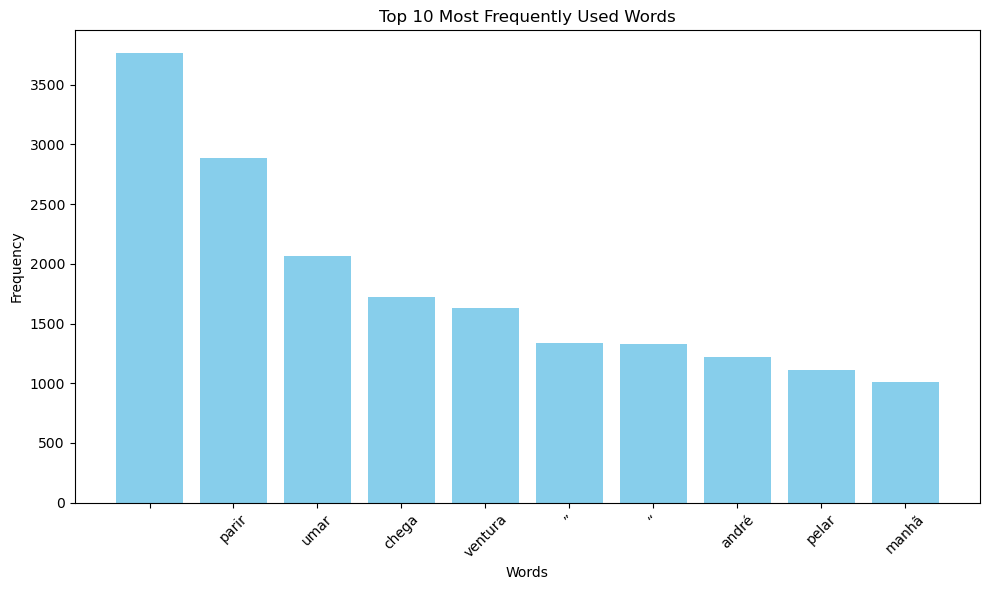

In [20]:
# Word Count
def w_counter(words):
    word_freq = Counter(words)
    common_words = word_freq.most_common()
    word_freq_dict = {"Word": [word for word, freq in common_words], "Frequency": [freq for word, freq in common_words]}
    return word_freq_dict

all_words = [word for sublist in filtered_df['Lemmas'] for word in sublist]

word_freq = pd.DataFrame(w_counter(all_words))

# Select the top 10 words by frequency
top_10_words = word_freq.head(10)

# Plot the top 10 words
plt.figure(figsize=(10, 6))
plt.bar(top_10_words['Word'], top_10_words['Frequency'], color='skyblue')
plt.title("Top 10 Most Frequently Used Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

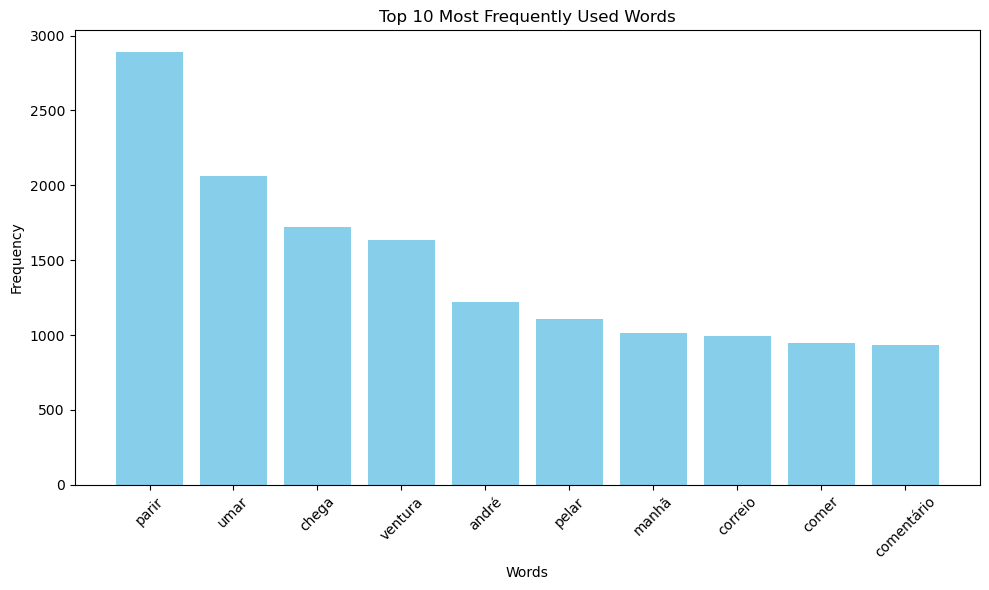

In [22]:
# preprocessing words and remove quotation marks and spaces

import re

# Clean and filter words
cleaned_words = [word for word in all_words if word.isalnum() and len(word) > 1]

# Updated word count function
def w_counter(words):
    word_freq = Counter(words)
    common_words = word_freq.most_common()
    word_freq_dict = {"Word": [word for word, freq in common_words], "Frequency": [freq for word, freq in common_words]}
    return word_freq_dict

# Generate word frequency dictionary
word_freq = pd.DataFrame(w_counter(cleaned_words))

# Select the top 10 words by frequency
top_10_words = word_freq.head(10)

# Plot the top 10 words
plt.figure(figsize=(10, 6))
plt.bar(top_10_words['Word'], top_10_words['Frequency'], color='skyblue')
plt.title("Top 10 Most Frequently Used Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Ngrams doesn't work properly right now

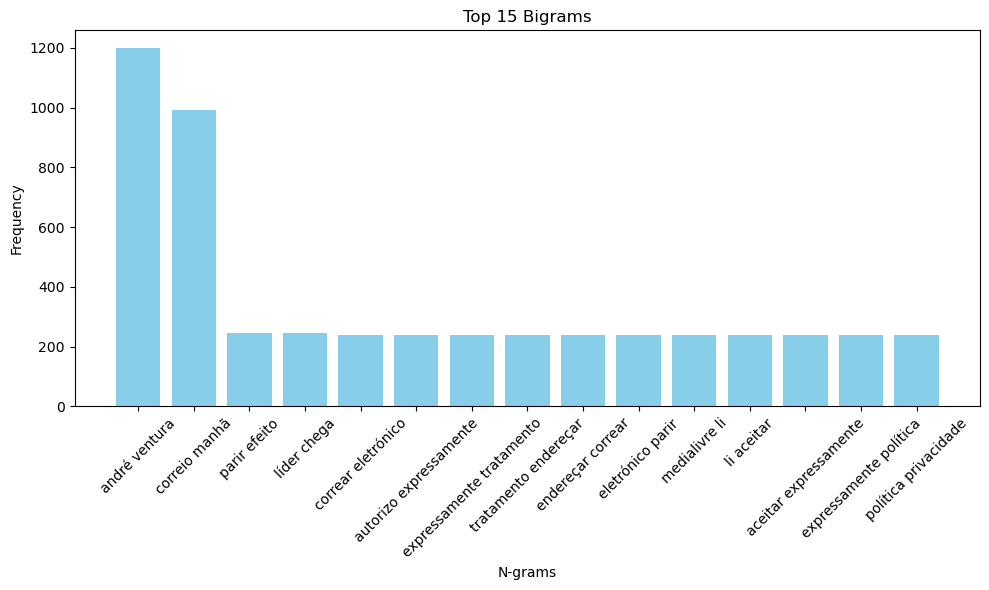

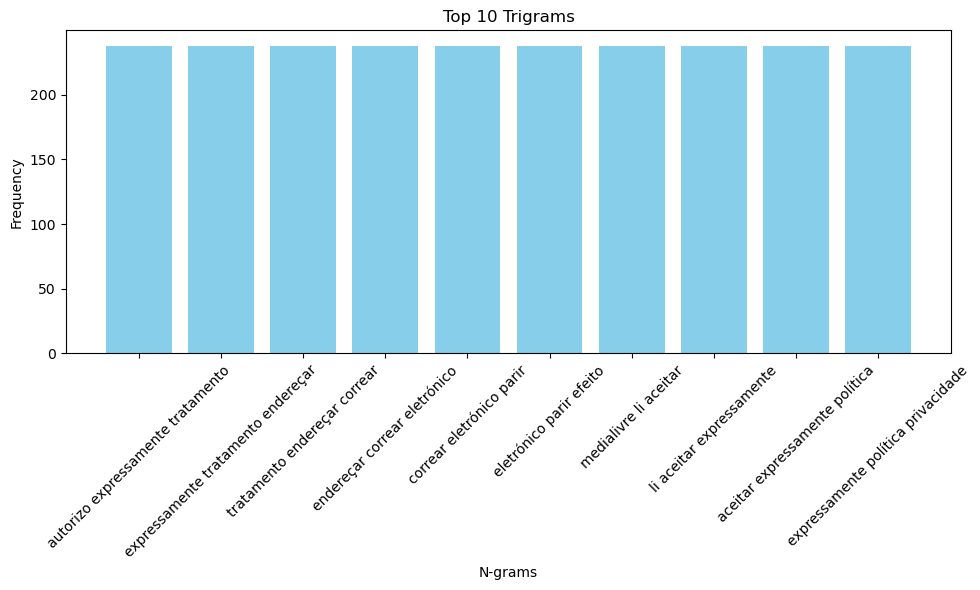

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from collections import Counter

# Create function to generate and plot n-grams
def generate_ngrams(corpus, ngram_range=(2, 2), top_n=10):
    # Create CountVectorizer for n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=None).fit(corpus)
    
    # Transform the corpus into a sparse matrix
    ngrams = vectorizer.transform(corpus)
    
    # Sum up frequencies of each n-gram
    ngram_counts = ngrams.sum(axis=0)
    ngram_frequencies = [(ngram, ngram_counts[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
    ngram_frequencies = sorted(ngram_frequencies, key=lambda x: x[1], reverse=True)[:top_n]
    
    # Separate n-grams and their frequencies
    ngram_words, ngram_freqs = zip(*ngram_frequencies)
    
    # Plot the top n n-grams
    plt.figure(figsize=(10, 6))
    plt.bar(ngram_words, ngram_freqs, color='skyblue')
    plt.title(f"Top {top_n} {'Bi' if ngram_range[1] == 2 else 'Tri'}grams")
    plt.xlabel("N-grams")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Combine the lemmatized words into a single corpus (list of sentences)
corpus = [' '.join(lemmas) for lemmas in updated_dfs['filtered_df_2020-2021']['Lemmas'].dropna()]

# Generate and plot bi-grams
generate_ngrams(corpus, ngram_range=(2, 2), top_n=15)

# Generate and plot tri-grams
generate_ngrams(corpus, ngram_range=(3, 3), top_n=10)


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(word_freq)

                                                   Word  Frequency
0                                                  de o      11814
1                                                  em o       4111
2                                                             3722
3                                                   a o       3442
4                                               ventura       1592
5                                                 chega       1478
6                                                     “       1261
7                                                     ”       1260
8                                               correio       1233
9                                                 andré       1187
10                                                por o       1177
11                                              partido       1110
12                                                manhã       1012
13                                           comentário       